# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 5
# Logistic Regression and PCA 

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [597]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
%matplotlib inline
import seaborn.apionly as sns
from sklearn.feature_selection import RFE
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

## Cancer Classification from Gene Expressions

In this homework assignment, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `dataset_hw5.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following parts, we will use logistic regression to build a classification model for this data set. We will also use principal components analysis (PCA) to visualize the data and to reduce its dimensions. 



## Part (a): Data Exploration

1. First step is to  split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).

2. Take a peak at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

3. Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

4. A convenient tool to visualize the gene expression data is a heat map. Arrange the rows of the training set so that the 'AML' rows are grouped together and the 'ALL' rows are together. Generate a heat map of the data with expression values from the following genes: 
`D49818_at`, `M23161_at`, `hum_alu_at`, `AFFX-PheX-5_at`, `M15990_at`. By observing the heat map, comment on which of these genes are useful in discriminating between the two classes.

5. We can also visualize this data set in two dimensions using PCA. Find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the AML and ALL points in different colors. How well do the top two principal components discriminate between the two classes?



In [2]:
np.random.seed(9001)
df = pd.read_csv('D:/Users/Home/Desktop/Open-U/Data Science/a-2017-master/HW/hw_5/dataset_hw5.csv')
#df.head()

In [24]:
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]
data_train1 = df[msk]
data_test1 = df[~msk]

In [42]:
cols=data_train.columns.tolist()
cols_to_norm=cols[1:]

In [7]:
len(cols_to_norm)

7129

In [13]:
def nozmalization(df,cols_to_norm):
     for i in range(0, len(cols_to_norm)):
        mean=np.mean(df[cols_to_norm[i]])
        SD=np.std(df[cols_to_norm[i]])
        df[cols_to_norm[i]+'_norm']=df[cols_to_norm[i]].apply(lambda x:(x-mean)/SD) 
     return df

In [15]:
df_train_norm=nozmalization(data_train,cols_to_norm)

d:\Users\Home\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [14]:
df_test_norm =nozmalization(data_test ,cols_to_norm)

d:\Users\Home\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [98]:
df_train_norm.head()

,Cancer_type,AFFX-BioB-5_at_norm,AFFX-BioB-M_at_norm,AFFX-BioB-3_at_norm,AFFX-BioC-5_at_norm,AFFX-BioC-3_at_norm,AFFX-BioDn-5_at_norm,AFFX-BioDn-3_at_norm,AFFX-CreX-5_at_norm,AFFX-CreX-3_at_norm,...,U48730_at_norm,U58516_at_norm,U73738_at_norm,X06956_at_norm,X16699_at_norm,X83863_at_norm,Z17240_at_norm,L49218_f_at_norm,M71243_f_at_norm,Z78285_f_at_norm
0,0,-0.791676,0.167948,-0.447255,-0.845754,-0.246131,-1.022135,0.870576,0.291435,1.669258,...,0.466958,-0.357791,-1.108935,0.398645,0.191747,0.118523,0.098478,0.640940,-0.460157,0.050765
5,0,0.520069,0.990551,0.560844,-1.455569,0.635758,0.512700,-0.201890,0.838050,-0.882506,...,-1.440910,-1.248533,0.908549,-0.603993,0.666444,-1.045266,-1.030341,0.128645,-0.797157,-0.844778
9,0,-3.129615,-0.654655,-0.163284,1.215999,-1.067200,0.048984,0.096731,0.648408,0.122126,...,1.246816,1.824063,1.639206,-0.290347,1.721327,2.223545,3.151775,1.098347,0.123047,-0.907258
12,0,1.269637,-0.874016,0.525347,0.412593,0.004752,-0.016328,1.275159,0.012550,-0.802136,...,1.023999,1.221958,-0.934450,-0.526867,-0.054392,1.604557,-0.191566,0.951977,0.157969,0.488123
13,0,-0.167036,-0.462714,-1.150085,-0.419852,0.848628,0.355951,-0.147304,1.987057,0.403422,...,-0.674978,-0.097086,0.123366,-1.416388,1.299374,-1.237686,-0.748136,-0.164094,-0.755250,0.363163


In [27]:
#df_train_norm.drop(cols_to_norm, axis=1, inplace=True)
#df_train_norm.head()

In [44]:
#df_test_norm.drop(cols_to_norm, axis=1, inplace=True)

In [22]:
def nozmalization_mm(df,cols_to_norm):
     for i in range(0, len(cols_to_norm)):
        minimum=np.min(df[cols_to_norm[i]])
        maximum=np.max(df[cols_to_norm[i]])
        dif=maximum-minimum 
        df[cols_to_norm[i]+'_norm_mm']=df[cols_to_norm[i]].apply(lambda x:(x-minimum)/dif) 
     return df

In [25]:
df_train_norm_mm =nozmalization_mm(data_train1 ,cols_to_norm)
df_test_norm_mm =nozmalization_mm(data_test1 ,cols_to_norm)

d:\Users\Home\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [908]:
df_train_norm_mm.shape

(34, 7131)

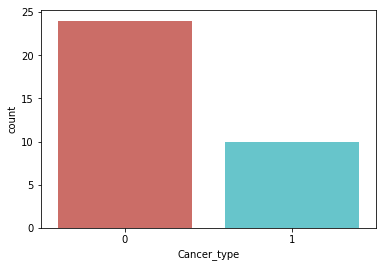

In [373]:
#train data
sns.countplot(x='Cancer_type',data=df_train_norm_mm,palette='hls')
plt.show()

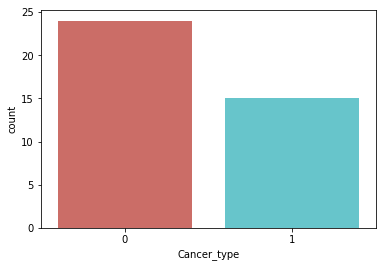

In [374]:
#test data
sns.countplot(x='Cancer_type',data=df_test_norm_mm,palette='hls')
plt.show()

In [ ]:
#3.with more predictors than data we can't build a qualified model.

In [29]:
df_train_norm_mm.drop(cols_to_norm, axis=1, inplace=True)
df_test_norm_mm.drop(cols_to_norm, axis=1, inplace=True)

d:\Users\Home\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
d:\Users\Home\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [109]:
#df_train_norm_mm.head()
#df_test_norm_mm.head()


0.43192443770533234

In [115]:
df_test_norm_mm_D49818=df_test_norm_mm[['Cancer_type','D49818_at_norm_mm' ]]
df_test_norm_mm_D49818=df_test_norm_mm_D49818.sort_values(by=["Cancer_type"])
print ('D49818 type-1',np.mean(df_test_norm_mm_D49818[df_test_norm_mm_D49818.Cancer_type==1]))
print ('D49818 type-0',np.mean(df_test_norm_mm_D49818[df_test_norm_mm_D49818.Cancer_type==0]))

df_test_norm_mm_M23161=df_test_norm_mm[['Cancer_type','M23161_at_norm_mm' ]]
df_test_norm_mm_M23161=df_test_norm_mm_M23161.sort_values(by=["Cancer_type"])
print ('M23161 type-1',np.mean(df_test_norm_mm_M23161[df_test_norm_mm_M23161.Cancer_type==1]))
print ('M23161 type-0',np.mean(df_test_norm_mm_M23161[df_test_norm_mm_M23161.Cancer_type==0]))


df_test_norm_mm_hum=df_test_norm_mm[['Cancer_type','hum_alu_at_norm_mm' ]]
df_test_norm_mm_hum=df_test_norm_mm_hum.sort_values(by=["Cancer_type"])

print ('hum type-1',np.mean(df_test_norm_mm_hum[df_test_norm_mm_hum.Cancer_type==1]))
print ('hum type-0',np.mean(df_test_norm_mm_hum[df_test_norm_mm_hum.Cancer_type==0]))

df_test_norm_mm_AFFX_PheX=df_test_norm_mm[['Cancer_type','AFFX-PheX-5_at_norm_mm' ]]
df_test_norm_mm_AFFX_PheX=df_test_norm_mm_AFFX_PheX.sort_values(by=["Cancer_type"])
print ('AFFX-PheX-5_at type-1',np.mean(df_test_norm_mm_AFFX_PheX[df_test_norm_mm_AFFX_PheX.Cancer_type==1]))
print ('AFFX-PheX-5_at type-0',np.mean(df_test_norm_mm_AFFX_PheX[df_test_norm_mm_AFFX_PheX.Cancer_type==0]))


df_test_norm_mm_M15990=df_test_norm_mm[['Cancer_type','M15990_at_norm_mm' ]]
df_test_norm_mm_M15990=df_test_norm_mm_M15990.sort_values(by=["Cancer_type"])
print ('M15990 type-1',np.mean(df_test_norm_mm_M15990[df_test_norm_mm_M15990.Cancer_type==1]))
print ('M15990 type-0',np.mean(df_test_norm_mm_M15990[df_test_norm_mm_M15990.Cancer_type==0]))


D49818 type-1 Cancer_type          1.000000
D49818_at_norm_mm    0.468537
dtype: float64
D49818 type-0 Cancer_type          0.000000
D49818_at_norm_mm    0.431924
dtype: float64
M23161 type-1 Cancer_type          1.000000
M23161_at_norm_mm    0.253284
dtype: float64
M23161 type-0 Cancer_type          0.000000
M23161_at_norm_mm    0.459791
dtype: float64
hum type-1 Cancer_type           1.000000
hum_alu_at_norm_mm    0.341892
dtype: float64
hum type-0 Cancer_type           0.000000
hum_alu_at_norm_mm    0.258607
dtype: float64
AFFX-PheX-5_at type-1 Cancer_type               1.000000
AFFX-PheX-5_at_norm_mm    0.485066
dtype: float64
AFFX-PheX-5_at type-0 Cancer_type               0.000000
AFFX-PheX-5_at_norm_mm    0.451016
dtype: float64
M15990 type-1 Cancer_type          1.000000
M15990_at_norm_mm    0.214113
dtype: float64
M15990 type-0 Cancer_type          0.000000
M15990_at_norm_mm    0.234454
dtype: float64


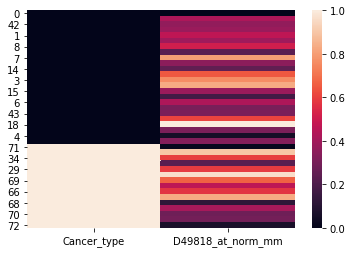

In [92]:
sns.heatmap(df_test_norm_mm_D49818)

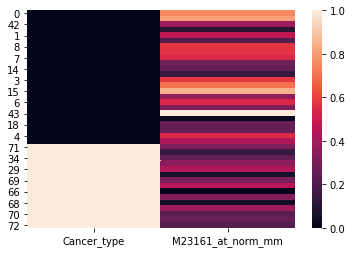

In [94]:
sns.heatmap(df_test_norm_mm_M23161)

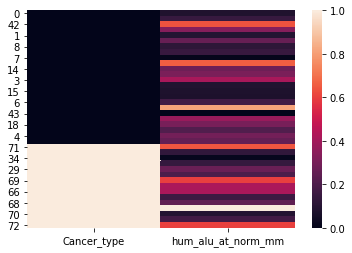

In [95]:
sns.heatmap(df_test_norm_mm_hum)

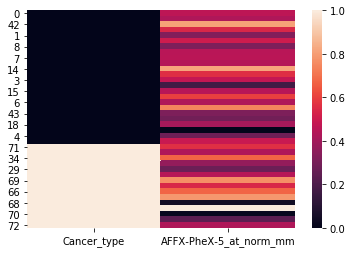

In [96]:
sns.heatmap(df_test_norm_mm_AFFX_PheX)

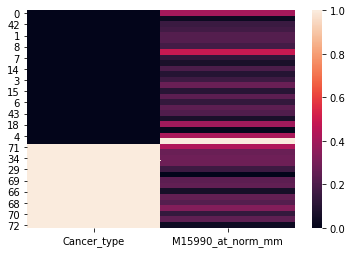

In [97]:
sns.heatmap(df_test_norm_mm_M15990)

In [113]:
# M23161_at seems to represent some correlation between the expression and the cancer type and to some extension hum_alu_at_norm.

In [ ]:
#We can also visualize this data set in two dimensions using PCA. Find the top two principal components for the
#gene expression data. Generate a scatter plot using these principal components, highlighting the AML and ALL points 
#in different colors. How well do the top two principal components discriminate between the two classes?

In [128]:
col_mm=df_train_norm_mm.columns.tolist()

In [182]:
X_norm_mm=df_train_norm_mm[col_mm[1:]].values
Y_norm_mm=df_train_norm_mm['Cancer_type'].values

X_norm_mm_test=df_test_norm_mm[col_mm[1:]].values
Y_norm_mm_test=df_test_norm_mm['Cancer_type'].values

In [771]:
pca = PCA(n_components=2)
pca.fit(X_norm_mm)
X_train_pca = pca.transform(X_norm_mm)
X_test_pca = pca.transform(X_norm_mm_test)

In [772]:
df_pca=pd.DataFrame(X_train_pca, columns=["PCA1", "PCA2"])
df_pca['Cancer_type']=Y_norm_mm

df_pca_test=pd.DataFrame(X_test_pca , columns=["PCA1", "PCA2"])
df_pca_test['Cancer_type']=Y_norm_mm_test

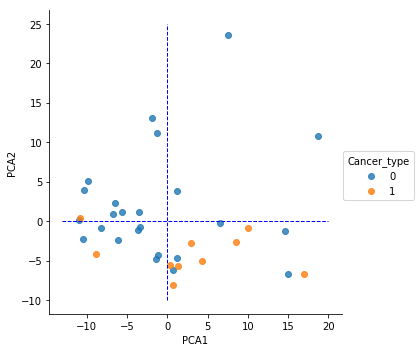

In [149]:
sns.lmplot(x="PCA1", y="PCA2",  data=df_pca, fit_reg=False,  hue="Cancer_type") 
plt.plot([0, 0], [-10, 25], '--',color='blue' , lw=1)
plt.plot([-13, 20], [0, 0], '--',color='blue' ,lw=1)

In [ ]:
#with PCA2<0 and PCA1>0, most likely that 
#the class is AML
#Let us check on the test

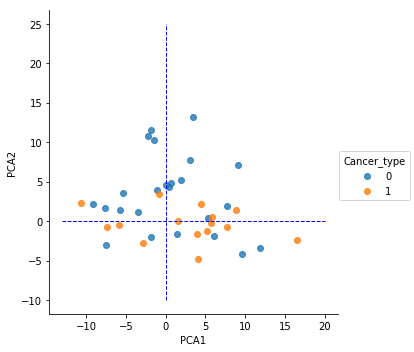

In [773]:
sns.lmplot(x="PCA1", y="PCA2",  data=df_pca_test, fit_reg=False,  hue="Cancer_type") 
plt.plot([0, 0], [-10, 25], '--',color='blue' , lw=1)
plt.plot([-13, 20], [0, 0], '--',color='blue' ,lw=1)

In [ ]:
#the separation plane might be shiftted.....not that obvious...

## Part (b): Linear Regression vs. Logistic Regression

Begin by analyzing the differences between using linear regression and logistic regression for classification. For this part, you shall work with a single gene predictor: `D29963_at`.

1. Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by regression model interpreted for a patient as an estimate of the probability that the patient has the `ALL` type cancer (class 1). Is there a problem with this interpretation?

2. The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into the `ALL` type (class 1), and the others into the `AML` type (class 0). Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.

3. Next, fit a simple logistic regression model to the training set. How does the training and test calssification accuracy of this model compare with the linear regression model?  Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order not to regularize (use 'C=100000').

4. Plot the quantitative output from linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot.
Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.



In [172]:
#1.
df_X_norm_train_D29963=pd.DataFrame(df_train_norm_mm['D29963_at_norm_mm'].values, columns=['D29963_at_norm_mm'])
df_X_norm_test_D29963=pd.DataFrame(df_test_norm_mm['D29963_at_norm_mm'].values, columns=['D29963_at_norm_mm'])
#df_X_norm_train_D29963['Cancer_type']=Y_norm_mm
#df_X_norm_train_D29963.head()

In [173]:
df_X_norm_train_D29963['1']= 1
df_X_norm_test_D29963['1']= 1
#df_test_norm_mm['Cancer_type']
#df_X_norm_train_D29963.head()

In [171]:
reg_D29963 = sm.OLS(df_pca['Cancer_type'],df_X_norm_train_D29963).fit()
reg_D29963.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Cancer_type   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     10.28
Date:                Mon, 22 Jan 2018   Prob (F-statistic):            0.00305
Time:                        12:12:33   Log-Likelihood:                -16.783
No. Observations:                  34   AIC:                             37.57
Df Residuals:                      32   BIC:                             40.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
D29963_at_norm_mm     1.0833      0.338      3.206      0.003       0.395       1.772
1                    -0.0843      0.137     -0.614      0.544      -0.364       0.195
==============================================================================
Omnibus:                        3.211   Durbin-Watson:                   0.435
Prob(Omnibus):                  0.201   Jarque-Bera (JB):                2.926
Skew:                           0.664   Prob(JB):                        0.232
Kurtosis:                       2.453   Cond. No.                         5.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#the linear regression is not a good model since the we are interested in probabilities - [0-1] range.
# the linear regression gives continuous result beyond this range.

In [ ]:
#The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary 
#labels  0 or 1) by classifying patients with predicted score greater than 0.5 into the ALL type (class 1), and the others into 
#the AML #type (class 0). Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model
#on both the training and test sets.

In [231]:
train_pred_D29963=reg_D29963.predict(df_X_norm_train_D29963)
test_pred_D29963=reg_D29963.predict(df_X_norm_test_D29963)
#predicted test train classifier
train_pred_D29963_class=train_pred_D29963.apply(lambda x:1 if x>0.5 else 0)
test_pred_D29963_class =test_pred_D29963.apply(lambda x:1 if x>0.5 else 0)


In [183]:
print('the accuracy of the train prediction is:',accuracy_score(Y_norm_mm, train_pred_D29963_class))
print('the accuracy of the test prediction is:',accuracy_score(Y_norm_mm_test, test_pred_D29963_class))

the accuracy of the train prediction is: 0.794117647059
the accuracy of the test prediction is: 0.74358974359


In [190]:
#Next, fit a simple logistic regression model to the training set. How does the training and test calssification accuracy of
#this model compare with the linear regression model? Remember, you need to set the regularization parameter for sklearn's 
#logistic regression function to be a very large value in order not to regularize (use 'C=100000').


In [216]:
log_reg_D29963 = LogisticRegression(C=100000, fit_intercept=False)
log_reg_D29963.fit(df_X_norm_train_D29963, Y_norm_mm)
log_reg_D29963_train_pred = log_reg_D29963.predict_proba(df_X_norm_train_D29963)[:,1]
log_reg_D29963_test_pred  = log_reg_D29963.predict_proba(df_X_norm_test_D29963)[:,1]


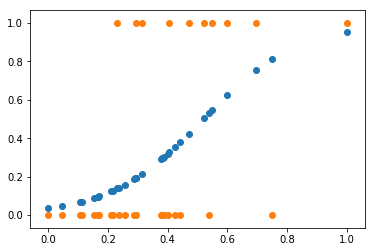

In [207]:
#train
plt.scatter(df_X_norm_train_D29963['D29963_at_norm_mm'],log_reg_D29963_train_pred)
plt.scatter(df_X_norm_train_D29963['D29963_at_norm_mm'],Y_norm_mm)

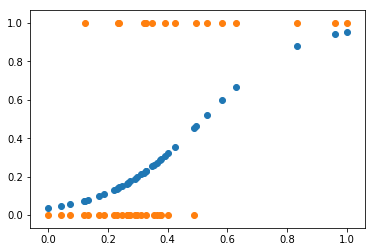

In [208]:
#test
plt.scatter(df_X_norm_test_D29963['D29963_at_norm_mm'],log_reg_D29963_test_pred)
plt.scatter(df_X_norm_test_D29963['D29963_at_norm_mm'],Y_norm_mm_test)

In [256]:
log_train_pred_D29963_class=pd.Series(log_reg_D29963_train_pred).apply(lambda x:1 if x>0.5 else 0)
log_test_pred_D29963_class =pd.Series(log_reg_D29963_test_pred ).apply(lambda x:1 if x>0.5 else 0)
print('the accuracy of the train prediction is:',accuracy_score(Y_norm_mm, log_train_pred_D29963_class))
print('the accuracy of the test prediction is:',accuracy_score(Y_norm_mm_test, log_test_pred_D29963_class))

the accuracy of the train prediction is: 0.794117647059
the accuracy of the test prediction is: 0.769230769231


In [ ]:
# the logistic regression is slightly better on the test class

In [258]:
#logistic
print(classification_report(Y_norm_mm, log_train_pred_D29963_class))

             precision    recall  f1-score   support

          0       0.81      0.92      0.86        24
          1       0.71      0.50      0.59        10

avg / total       0.79      0.79      0.78        34



In [259]:
#simple
print(classification_report(Y_norm_mm, train_pred_D29963_class))

             precision    recall  f1-score   support

          0       0.79      0.96      0.87        24
          1       0.80      0.40      0.53        10

avg / total       0.80      0.79      0.77        34



In [260]:
#Plot the quantitative output from linear regression model and the probabilistic output from the logistic regression model
#(on the training set points) as a function of the gene predictor. Also, display the true binary response for the training
#set points in the same plot. Based on these plots, does one of the models appear better suited for binary classification 
#than the other? Explain.

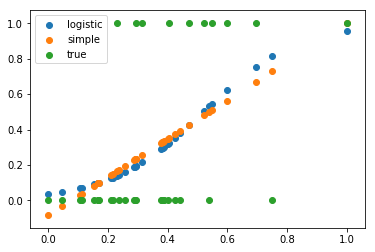

In [264]:
#train
plt.scatter(df_X_norm_train_D29963['D29963_at_norm_mm'],log_reg_D29963_train_pred,label='logistic')
plt.scatter(df_X_norm_train_D29963['D29963_at_norm_mm'],train_pred_D29963,label='simple')
plt.scatter(df_X_norm_train_D29963['D29963_at_norm_mm'],Y_norm_mm,label='true')

plt.legend()

In [294]:
log_reg_tot = LogisticRegression(C=100000, fit_intercept=False)
log_reg_tot.fit(X_norm_mm, Y_norm_mm)

LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [295]:
log_reg_tot_train_pred = log_reg_tot.predict_proba(X_norm_mm)[:,1]
log_reg_tot_test_pred  = log_reg_tot.predict_proba(X_norm_mm_test)[:,1]

log_train_pred_tot_class=pd.Series(log_reg_tot_train_pred).apply(lambda x:1 if x>0.5 else 0)
log_test_pred_tot_class =pd.Series(log_reg_tot_test_pred).apply(lambda x:1 if x>0.5 else 0)

print('the accuracy of the train prediction with all predictors is:',accuracy_score(Y_norm_mm, log_train_pred_tot_class))
print('the accuracy of the test prediction with all predictors is:',accuracy_score(Y_norm_mm_test, log_test_pred_tot_class))

the accuracy of the train prediction with all predictors is: 1.0
the accuracy of the test prediction with all predictors is: 0.769230769231


In [487]:
log_reg_tot.predict_proba

<bound method LogisticRegression.predict_proba of LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)>

In [269]:
# starter code
from HW5_functions import visualize_prob

In [278]:
#--------  visualize_prob
# A function to visualize the probabilities predicted by a Logistic Regression model
# Input: 
#      model (Logistic regression model)
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data: 0 or 1)
#      ax (an axis object to generate the plot)

def visualize_prob(model, x, y, ax):
    # Use the model to predict probabilities for
    y_pred = model.predict_proba(x)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bx', label = 'ALL')
    neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'rx', label = 'AML')
    
    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of AML class')
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])

In [279]:
#2. "Use the `visualize_prob` from `HW5_functions.py` to visualize the probabilties predicted by the fitted multiple logistic 
#regression model on both the training and test data sets. The function creates a visualization that places the data points on 
#a vertical line based on the predicted probabilities, with the `ALL` and `AML` classes shown in different colors, and with the 
#0.5 threshold highlighted using a dotted horizontal line.  Is there a difference in the spread of probabilities in the training
#and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these
#points?"

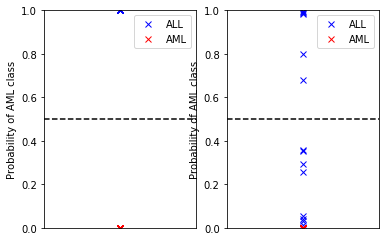

In [280]:
f, (ax1, ax2) = plt.subplots(1, 2)
visualize_prob(log_reg_tot, X_norm_mm, Y_norm_mm, ax1)
visualize_prob(log_reg_tot, X_norm_mm_test, Y_norm_mm_test, ax2)

In [ ]:
#The predictive model performes well on the train set, 
#however,on the test set,there ar a lot of misclassified samples ,all of them are drom  ALL class.
# the predictive model is doing good both on the train and test sets for AML class

In [345]:
df_train_norm_mm['1'] = 1.0
x_train_all=df_train_norm_mm[col_mm[1:]].values
y_train_all=df_train_norm_mm['Cancer_type'].values.reshape(len(y_train_all),1)
y_train_all.shape

d:\Users\Home\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(34, 1)

## Part (d): Analyzing Significance of Coefficients

How many of the coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a *significance level of 95%*? 

Hint: To answer this question, use *bootstrapping* with 100 boostrap samples/iterations.  



In [491]:
df_train_norm_mm[col_mm[1:]].shape[1]

7129

In [570]:
iterations=300
try_table = np.zeros((df_train_norm_mm[col_mm[1:]].shape[1],iterations))

for i in range(iterations):   
    boot_rows = np.random.choice(range(df_train_norm_mm[col_mm[1:]].shape[0]), size=df_train_norm_mm[col_mm[1:]].shape[0], replace=True)
    X_train_try = df_train_norm_mm[col_mm[1:]].values[boot_rows]
    y_train_try = df_train_norm_mm['Cancer_type'].values[boot_rows]
    log_try = LogisticRegression(C=100000, fit_intercept=False)
    log_try.fit(X_train_try, y_train_try)
    try_table[:,i] = log_try.coef_

In [571]:
mean_coef=[]
SE=[]
p_val=[]
#P=exp(−0.717×z − 0.416×z2).

In [572]:
#by formula
for i in range(df_train_norm_mm[col_mm[1:]].shape[1]):
    mean_coef.append(np.mean(try_table[i]))
    SE.append(np.std(try_table[i]))
    z=np.mean(try_table[i])/np.std(try_table[i])
    p_val.append(math.exp(-0.717*z-0.416*z*z))

In [810]:
df_stat=pd.DataFrame({'name':col_mm[1:]})
df_stat['mean_coef']=mean_coef
df_stat['SE']=SE
df_stat['p_val']=p_val

In [902]:
important_gens=df_stat[df_stat.p_val<0.05]
len(important_gens)

874

In [ ]:
#by calculationof percentile

In [577]:
up_bound = np.percentile( try_table, 97.5, axis=1)
low_bound = np.percentile( try_table, 2.5, axis=1)
up_bound 

array([ 0.05379211,  0.03014879,  0.01869492, ...,  0.0073571 ,
        0.09795149, -0.00067186])

In [581]:
# ct significant predictors
num_c = 0
for i in range(df_train_norm_mm[col_mm[1:]].shape[1]):
    if up_bound[i]<0 or low_bound[i]>0:
        num_c+= 1

print("The number of significant coeffs is = %i / %i" % (num_c ,df_train_norm_mm[col_mm[1:]].shape[1]))

The number of significant coeffs is = 1865 / 7129


In [825]:
# Let us try to perform log_reg with the chosen predictors.
imp_gens_names=important_gens.name.tolist()
x_train_imp=df_train_norm_mm[imp_gens_names].values
y_train_imp=df_train_norm_mm['Cancer_type'].values.reshape(len(y_train_all),1)
x_test_imp=df_test_norm_mm[imp_gens_names].values
y_train_imp.shape

(34, 1)

In [819]:
log_reg_imp = LogisticRegression(C=100000, fit_intercept=False)
log_reg_imp.fit(x_train_imp, y_train_imp)
log_reg_imp_train_pred = log_reg_imp.predict_proba(x_train_imp)[:,1]
log_reg_imp_test_pred  = log_reg_imp.predict_proba(x_test_imp)[:,1]

log_train_pred_imp_class=pd.Series(log_reg_imp_train_pred).apply(lambda x:1 if x>0.5 else 0)
log_test_pred_imp_class =pd.Series(log_reg_imp_test_pred).apply(lambda x:1 if x>0.5 else 0)

print('the accuracy of the train prediction with all predictors is:',accuracy_score(y_train_imp, log_train_pred_imp_class))
print('the accuracy of the test prediction with all predictors is:',accuracy_score(Y_norm_mm_test, log_test_pred_imp_class))

the accuracy of the train prediction with all predictors is: 1.0
the accuracy of the test prediction with all predictors is: 0.948717948718


d:\Users\Home\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# General note: both Logistic regression and PCA are not recommended for this case, the training samples set is very small, 
#(34 samples), thus the log_reg is not the best choice. The PCA is a bad option since it might not caprute the discriminant 
#dimension.However, it is possible to make LDA after PCA....

## Part (e): Dimensionality Reduction using PCA

A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the first set of principal components contributing to 90% of the variance in the predictors.

1. How do the classification accuracy values on both the training and tests sets compare with the models fitted in Parts (c) and (d)?  

2. Re-fit a logistic regression model using 5-fold cross-validation to choose the number of principal components, and comment on whether you get better test performance than the model fitted above (explain your observations). 

3. Use the code provided in Part (c) to visualize the probabilities predicted by the fitted models on both the training and test sets. How does the spread of probabilities in these plots compare to those for the models in Part (c) and (d)? 


In [591]:
#-
model_PCA = PCA()
model_PCA .fit_transform(X_norm_mm)
vec=model_PCA.explained_variance_ratio_.cumsum()
vec

array([ 0.18893916,  0.3073883 ,  0.36548155,  0.41383942,  0.45930091,
        0.50010267,  0.53259045,  0.56448293,  0.59443451,  0.62108816,
        0.64656392,  0.67119947,  0.69505045,  0.71810619,  0.73984841,
        0.7598315 ,  0.77861118,  0.79714619,  0.81478413,  0.83200937,
        0.84853772,  0.86398847,  0.87870503,  0.89332422,  0.9076768 ,
        0.92150368,  0.93438992,  0.94713374,  0.95843735,  0.96965489,
        0.98054716,  0.99075779,  1.        ,  1.        ])

In [593]:
c=0
for i in range(len(vec)):
    if vec[i]<0.9:
        c=c+1
print(c)        

24


In [ ]:
#first 24 components contribute to 90% of variance

In [820]:
#Let us try to work with the most important genes predicted in the previous section
model_PCA .fit_transform(x_train_imp)
vec1=model_PCA.explained_variance_ratio_.cumsum()
vec1
# seems 21 components contribute to 90% of variance from the most important genes

array([ 0.25396494,  0.38201336,  0.47479353,  0.52361002,  0.56452317,
        0.5975771 ,  0.62886272,  0.65741028,  0.68386826,  0.70823813,
        0.73143041,  0.75245161,  0.77186287,  0.79024057,  0.80679081,
        0.82316937,  0.83834547,  0.85267129,  0.86662591,  0.87976102,
        0.89280504,  0.90481687,  0.91661997,  0.9278395 ,  0.9382182 ,
        0.94746314,  0.95623709,  0.96460925,  0.97232523,  0.97998962,
        0.9872106 ,  0.99382886,  1.        ,  1.        ])

In [848]:
#1.
model_PCA_train = PCA(n_components=23)
model_PCA_train.fit(X_norm_mm)
X_train_pca_1 = model_PCA_train.transform(X_norm_mm)
X_test_pca_1 = model_PCA_train.transform(X_norm_mm_test)

X_test_pca_1.shape

(39, 23)

In [627]:
log_reg_pca = LogisticRegression(C=100000, fit_intercept=True)
log_reg_pca.fit(X_train_pca_1, Y_norm_mm)
log_reg_pca_train=log_reg_pca.predict_proba(X_train_pca_1)[:,1]
log_reg_pca_test=log_reg_pca.predict_proba(X_test_pca_1)[:,1]

log_train_pred_pca_class=pd.Series(log_reg_pca_train).apply(lambda x:1 if x>0.5 else 0)
log_test_pred_pca_class =pd.Series(log_reg_pca_test).apply(lambda x:1 if x>0.5 else 0)

# accuracy
print("log regression PCA train",accuracy_score(y_train_all, log_train_pred_pca_class))
print("log regression PCA test",accuracy_score(Y_norm_mm_test, log_test_pred_pca_class))

log regression PCA train 1.0
log regression PCA test 0.923076923077


In [ ]:
#This model performing better on the test set than the model in part C
#

In [598]:
n_folds=5
kfold = KFold(n_folds)
accuracy_train = np.zeros((25,n_folds))
accuracy_valid = np.zeros((25,n_folds))

In [731]:
fold = 0
for train, valid in KFold(n_folds, shuffle=True).split(range(34)): # split data into train/test groups,10 times
    train_dict, valid_dict = X_norm_mm[train], X_norm_mm[valid]  
    y_train_dict, y_valid_dict = Y_norm_mm[train], Y_norm_mm[valid] 
    
    pca = PCA()
    pca.fit(train_dict)
    train_dict_pca = pca.transform(train_dict)
    valid_dict_pca = pca.transform(valid_dict)
    
    for i in range(1,25):    
        est = LogisticRegression(fit_intercept=True)
        est.fit(train_dict_pca[:,:i], Y_norm_mm[train]) 
        train_predict=est.predict(train_dict_pca[:,:i])
        valid_predict=est.predict(valid_dict_pca[:,:i])
    
        accuracy_train[i,fold] = accuracy_score(y_train_dict, train_predict)
        accuracy_valid[i,fold] = accuracy_score(y_valid_dict, valid_predict) 
    fold += 1     

In [707]:
accuracy_valid.shape[0]

25

In [723]:
def PCA_range(accuracy_train):
    mean_=[]
    meanSe=[]
    mean_Se=[]
    for i in range( accuracy_train.shape[0]):
        mean_.append(np.mean( accuracy_train[i]))
        meanSe.append(np.mean( accuracy_train[i])+np.std(accuracy_train[i]))
        mean_Se.append(np.mean( accuracy_train[i])-np.std(accuracy_train[i]))
    return mean_,meanSe,mean_Se

In [724]:
mean_=[]
meanSe=[]
mean_Se=[]
mean_,meanSe,mean_Se=PCA_range(accuracy_train)
len(mean_)

25

In [725]:
mean_v=[]
meanSev=[]
mean_Sev=[]
mean_v,meanSev,mean_Sev=PCA_range(accuracy_valid)
len(mean_v)

25

In [767]:
x=np.linspace(0,25,25)

(0.5, 1.1)

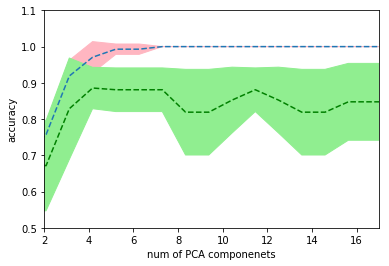

In [746]:
plt.plot(x,mean_,'--',label='train')
plt.fill_between(x,mean_Se,meanSe,color='lightpink')

plt.plot(x,mean_v,'--',color='green',label='validation')
plt.fill_between(x,mean_Sev,meanSev,color='lightgreen')

plt.ylabel("accuracy")
plt.xlabel("num of PCA componenets")
plt.xlim(2,17)
plt.ylim(0.5,1.1)

---
 

In [ ]:
#it seems that the traininf set accuracy achieves max with 6 > components,while the validation set achieves max accuracy at 7.
#let us perform log_reg with 6 pca components on the 

In [776]:
y_train_all.shape
Y_norm_mm_test.shape

(39, 7)

In [793]:
pca_test_6 = LogisticRegression(fit_intercept=True)
pca_test_6.fit(train_dict_pca[:,:6], y_train_dict) 
train_predict_6=pca_test_6.predict_proba(train_dict_pca[:,:6])[:,1]
test_predict_6=pca_test_6.predict_proba(X_test_pca_1[:,:6] )[:,1]

train_predict_6_class=pd.Series(train_predict_6).apply(lambda x:1 if x>0.5 else 0)
test_predict_6_class =pd.Series(test_predict_6).apply(lambda x:1 if x>0.5 else 0)

# accuracy
print("log regression PCA train",accuracy_score(y_train_dict, train_predict_6_class))
print("log regression PCA test",accuracy_score(Y_norm_mm_test, test_predict_6_class))

log regression PCA train 1.0
log regression PCA test 0.641025641026


In [794]:
# slightly better than a random guess.....on the test set.

In [795]:
#3.Use the code provided in Part (c) to visualize the probabilities predicted 
#  by the fitted models on both the training and test sets. How does the spread of 
#  probabilities in these plots compare to those for the models in Part (c) and (d)?

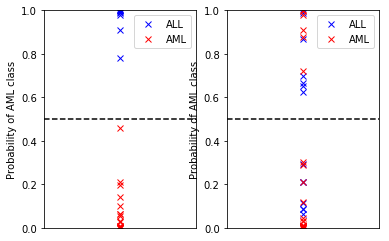

In [859]:
f, (ax1, ax2) = plt.subplots(1, 2)
visualize_prob(pca_test_6, train_dict_pca[:,:6], y_train_dict, ax1)
visualize_prob(pca_test_6, X_test_pca_1[:,:6], Y_norm_mm_test, ax2)

In [ ]:
#THough we reduced the dimenssion, the performance of the model on the test set is quite poor, no
#it is just slightly better than a random guess.

In [849]:
# We will try to perfrom all the above steps for the chosen: most important genes
model_PCA_traini = PCA(n_components=23)
model_PCA_traini.fit(x_train_imp)
X_train_pca_2 = model_PCA_traini.transform(x_train_imp)
X_test_pca_2 = model_PCA_traini.transform(x_test_imp)


In [903]:
accuracy_traini = np.zeros((25,n_folds))
accuracy_validi = np.zeros((25,n_folds))
fold = 0
for train, valid in KFold(n_folds, shuffle=True).split(range(34)): # split data into train/test groups,10 times
    train_dicti, valid_dicti = x_train_imp[train], x_train_imp[valid]  
    y_train_dicti, y_valid_dicti = y_train_imp[train], y_train_imp[valid] 
    
    pca = PCA()
    pca.fit(train_dicti)
    train_dict_pcai = pca.transform(train_dicti)
    valid_dict_pcai = pca.transform(valid_dicti)
    
    for i in range(1,25):    
        est = LogisticRegression(fit_intercept=True)
        est.fit(train_dict_pcai[:,:i], y_train_imp[train]) 
        train_predicti=est.predict(train_dict_pcai[:,:i])
        valid_predicti=est.predict(valid_dict_pcai[:,:i])
    
        accuracy_traini[i,fold] = accuracy_score(y_train_dicti, train_predicti)
        accuracy_validi[i,fold] = accuracy_score(y_valid_dicti, valid_predicti) 
    fold += 1    

d:\Users\Home\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [904]:
imean_=[]
imeanSe=[]
imean_Se=[]
imean_,imeanSe,imean_Se=PCA_range(accuracy_traini)
imean_v=[]
imeanSev=[]
imean_Sev=[]
imean_v,imeanSev,imean_Sev=PCA_range(accuracy_validi)
len(imean_Se)

25

(0.5, 1.1)

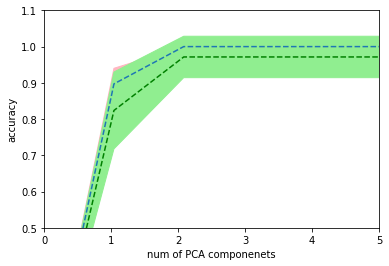

In [905]:
x=np.linspace(0,25,25)
plt.plot(x,imean_,'--',label='train')
plt.fill_between(x,imean_Se,imeanSe,color='lightpink')

plt.plot(x,imean_v,'--',color='green',label='validation')
plt.fill_between(x,imean_Sev,imeanSev,color='lightgreen')

plt.ylabel("accuracy")
plt.xlabel("num of PCA componenets")
plt.xlim(0,5)
plt.ylim(0.5,1.1)

In [885]:
#Good performance with even 2 components...., both train and validation

In [906]:
pca_test_3 = LogisticRegression(fit_intercept=True)
pca_test_3.fit(train_dict_pcai[:,:2], y_train_dicti) 
train_predict_3=pca_test_3.predict_proba(train_dict_pcai[:,:2])[:,1]
test_predict_3=pca_test_3.predict_proba(X_test_pca_2[:,:2] )[:,1]

train_predict_3_class=pd.Series(train_predict_3).apply(lambda x:1 if x>0.5 else 0)
test_predict_3_class =pd.Series(test_predict_3).apply(lambda x:1 if x>0.5 else 0)

# accuracy
print("log regression PCA train",accuracy_score(y_train_dicti, train_predict_3_class))
print("log regression PCA test",accuracy_score(Y_norm_mm_test, test_predict_3_class))

log regression PCA train 1.0
log regression PCA test 0.923076923077


d:\Users\Home\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


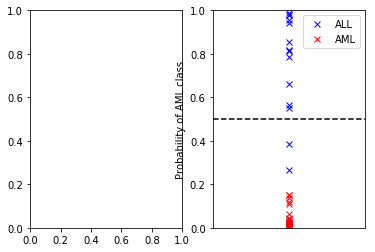

In [907]:
f, (ax1, ax2) = plt.subplots(1, 2)
visualize_prob(pca_test_3, X_test_pca_2[:,:2], Y_norm_mm_test, ax2)

In [ ]:
# Keeping only the most important 874 genes , and constructing 2 PCA components has good accuracy performance.
#All the AML were classified correctly, while the problem was with the ALL clasifier.

# APCOMP209a - Homework Question

Suppose we want to conduct PCA on the model matrix $X \in \Re^{n×p}$, where the columns have been suitably set to zero mean. In this question, we consider the squared reconstruction error:

$$  \parallel XQ- XQ_m \parallel ^2 $$

for a suitable set of eigenvectors forming the matrix $Q_m$, as discussed below. Suppose that we conduct eigendecomposition of $X^T X$ and obtain eigenvalues $\lambda_1, \ldots , \lambda_p$ and principal components $Q$, i.e.

$$ X^T X = Q \Lambda Q ^T $$

(1) Suppose that the matrix norm is simply the squared dot product, namely

$$ \parallel A \parallel ^2 = A^T A $$

Then, express the reconstruction error as a sum of matrix products.

(2) Simplify your result from (1) based on properties of the matrices $Q$.

(3) Now let $Q_m$ be the matrix of the first $m < p$ eigenvectors, namely

$$ Q_m = (q_1, \ldots, q_m, 0, \ldots, 0) \in \Re^{p \times p} $$

Thus, $X Q_m$ is the PCA projection of the data into the space spanned by the first $m$ principal components. Express the products $Q^T_m Q$ and $Q^T Q_m$, again using properties of the eigenbasis $q_1, \ldots, q_p$.

(4) Use your results from (3) to finally fully simplify your expression from (2).

(5) Note that the result you obtain should still be a matrix, i.e. this does not define a proper norm on the space of matrices (since the value should be a scalar). Consequently, the true matrix norm is actually the trace of the
above result, namely

$$ \parallel A \parallel ^2  = {\rm trace} (A^T A) $$
Use your result from (4) and this new definition to find a simple expression
for the reconstruction error in terms of the eigenvalues.

(6) Interpret your result from (5). In light of your results, does our procedure for PCA (selecting the $m$ substantially larger eigenvalues) make sense? Why or why not?